In [2]:
import torch
import torch.nn as nn
import collections
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

In [3]:
np.random.seed(42)

In [4]:
TRAIN_FILE = 'train_emoji_cleaned.csv'
TEST_FILE = 'test_emoji_cleaned.csv'
train_voc = ''

In [5]:
def tokenize(lines, token='word'):
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print("error: unknown type")

In [6]:
def count_corpus(tokens):
    if len(tokens) == 0 or isinstance(tokens[0], list):
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [7]:
class Vocab:
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []

        if reserved_tokens is None:
            reserved_tokens = []

        counter = count_corpus(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        self.unk, uniq_tokens = 0, ['<unk>'] + reserved_tokens

        uniq_tokens += [
            token for token, freq in self.token_freqs
            if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

In [8]:
global train_voc
train_raw_data = pd.read_csv(TRAIN_FILE)
train_text_list = list()

for single_text in train_raw_data.Tweet:
    single_text = re.sub(r'[\W]+', ' ', single_text.lower())
    single_text = single_text.replace('hadn t', 'had not')
    single_text = single_text.replace('wasn t', 'was not')
    single_text = single_text.replace('didn t', 'did not')
    single_text = single_text.replace('havent', 'have not')
    single_text = single_text.replace('isn t', 'is not')
    single_text = single_text.replace('isnt', 'is not')
    single_text = single_text.replace('doesnt', 'does not')
    single_text = single_text.replace('dont', 'do not')
    single_text = single_text.replace('hasnt', 'has not')
    single_text = single_text.replace('arent', 'are not')
    single_text = single_text.replace('•', '')
    single_text = single_text.replace('••', '')
    single_text = single_text.replace('  ', ' ')
    single_text = single_text.replace('   ', ' ')

    train_text_list.append(single_text)

train_tokens = tokenize(train_text_list)
train_voc = Vocab(tokens=train_tokens, min_freq=50)

list_init = list()
for i in range(len(train_raw_data)):
    list_init.append(np.zeros(len(train_voc) - 1))

train_cleaned = train_raw_data
train_cleaned['tokens'] = list_init

list_init.clear()
for i in range(len(train_raw_data)):
    list_init.append(np.zeros(20))

train_cleaned['emo_vecs'] = list_init

clean_tokens = np.zeros((len(train_raw_data), len(train_voc) - 1))
clean_emos = np.zeros((len(train_raw_data), 20))

for i in range(len(train_cleaned)):
    cur_text = train_cleaned.iloc[i]['Tweet']
    cur_words = cur_text.split()
    cur_indices = np.zeros(len(train_voc) - 1)

    for word in cur_words:
        temp_index = train_voc[word]
        if temp_index == 0:
            continue
        cur_indices[temp_index - 1] += 1

    train_cleaned.at[i, 'tokens'] = cur_indices
    clean_tokens[i] = cur_indices

    cur_emos = np.zeros(20)
    cur_emos[train_cleaned.iloc[i]['Label']] = 1

    train_cleaned.at[i, 'emo_vecs'] = cur_emos
    clean_emos[i] = cur_emos

In [9]:
train_cleaned, clean_tokens, clean_emos

(                                                   Tweet  Label  \
 0      a little throwback with my favourite person  w...      0   
 1      glam on  yesterday for kcon makeup using  in f...      7   
 2      democracy plaza in the wake of a stunning outc...     11   
 3           then amp now vilo  walt disney magic kingdom      0   
 4                       who never  a galaxy far far away      2   
 ...                                                  ...    ...   
 39995  date night  outback steakhouse  birmingham  fu...      0   
 39996  just taking some time out of my day to say i a...      0   
 39997                     parenthood binge watch all day      5   
 39998  saturday morning building project futurehandym...      8   
 39999  ️love last nights adventure to lookout mountai...      0   
 
                                                   tokens  \
 0      [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...   
 1      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...   

In [10]:
print(train_voc.token_to_idx)

{'<unk>': 0, 'the': 1, 'my': 2, 'to': 3, 'i': 4, 'a': 5, 'you': 6, 'in': 7, 'and': 8, 'of': 9, 'with': 10, 'for': 11, 'this': 12, 'love': 13, 'is': 14, 'at': 15, 'new': 16, 'on': 17, 'so': 18, 'me': 19, 'it': 20, 'happy': 21, 'day': 22, 'amp': 23, 'we': 24, 'be': 25, 'not': 26, 'was': 27, 'all': 28, 'im': 29, 'that': 30, 'from': 31, 'your': 32, 'beach': 33, 'its': 34, 'night': 35, 'do': 36, 'just': 37, 'have': 38, 'one': 39, 'best': 40, 'york': 41, 'out': 42, 'when': 43, 'park': 44, 'are': 45, 'good': 46, 'today': 47, 'time': 48, 'our': 49, 'but': 50, 'up': 51, 'by': 52, 'university': 53, 'christmas': 54, 'like': 55, 'birthday': 56, 'these': 57, 'city': 58, 'last': 59, 'got': 60, 'little': 61, 'thanks': 62, 'beautiful': 63, 'get': 64, 'great': 65, 'what': 66, 'california': 67, 'see': 68, 'back': 69, 'center': 70, 'family': 71, 'life': 72, 'school': 73, 'thank': 74, 'favorite': 75, 'some': 76, 'had': 77, 'much': 78, 'fun': 79, 'cant': 80, 'home': 81, 'always': 82, 'first': 83, 'her': 84

In [11]:
global train_voc
test_raw_data = pd.read_csv(TEST_FILE)
train_text_list = list()

for single_text in test_raw_data.Tweet:
    single_text = re.sub(r'[\W]+', ' ', single_text.lower())
    single_text = single_text.replace('hadn t', 'had not')
    single_text = single_text.replace('wasn t', 'was not')
    single_text = single_text.replace('didn t', 'did not')
    single_text = single_text.replace('havent', 'have not')
    single_text = single_text.replace('isn t', 'is not')
    single_text = single_text.replace('isnt', 'is not')
    single_text = single_text.replace('doesnt', 'does not')
    single_text = single_text.replace('dont', 'do not')
    single_text = single_text.replace('hasnt', 'has not')
    single_text = single_text.replace('arent', 'are not')
    single_text = single_text.replace('•', '')
    single_text = single_text.replace('••', '')
    single_text = single_text.replace('  ', ' ')
    single_text = single_text.replace('   ', ' ')

    train_text_list.append(single_text)

list_init = list()
for i in range(len(test_raw_data)):
    list_init.append(np.zeros(len(train_voc) - 1))

test_cleaned = test_raw_data
test_cleaned['tokens'] = list_init

list_init.clear()
for i in range(len(test_raw_data)):
    list_init.append(np.zeros(20))

test_cleaned['emo_vecs'] = list_init

test_tokens = np.zeros((len(test_raw_data), len(train_voc) - 1))
test_emos = np.zeros((len(test_raw_data), 20))

for i in range(len(test_cleaned)):
    cur_text = test_cleaned.iloc[i]['Tweet']
    cur_words = cur_text.split()
    cur_indices = np.zeros(len(train_voc) - 1)

    for word in cur_words:
        temp_index = train_voc[word]
        if temp_index == 0:
            continue
        cur_indices[temp_index - 1] += 1

    test_cleaned.at[i, 'tokens'] = cur_indices
    test_tokens[i] = cur_indices

    cur_emos = np.zeros(20)
    cur_emos[test_cleaned.iloc[i]['Label']] = 1

    test_cleaned.at[i, 'emo_vecs'] = cur_emos
    test_emos[i] = cur_emos

In [12]:
test_cleaned, test_tokens, test_emos

(                                                  Tweet  Label  \
 0     pho mi amor pho oceanbeach tourunicos siddhart...      1   
 1     this made possible by a beautiful lady thanks ...      1   
 2     throwback to  when i went to detroit amp got k...      2   
 3     obamas last tree lighting  national christmas ...     17   
 4     kicking the new year off right w my bff  shipp...      0   
 ...                                                 ...    ...   
 9994  my ootd love this chain so much and our new ri...      1   
 9995  met santa and olaf  the north pole today  nort...      0   
 9996  new york by night strideby herelocationnyc see...     11   
 9997    kisses for the birthday girl  helzberg diamonds      0   
 9998  dinner with this priceless viewthank you s ann...      9   
 
                                                  tokens  \
 0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
 1     [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...   
 2     [0.0, 0

In [13]:
def get_accuracy(Y_pred, Y):
    ct, ttl_ct = 0, 0
    for i in range(len(Y_pred)):
        ct += (np.argmax(Y_pred[i]) == np.argmax(Y[i]))
        ttl_ct += 1
    return ct / ttl_ct

In [14]:
num_data = len(clean_tokens)
x_size = len(clean_tokens[0])

In [ ]:
n_in, n_h1, n_h2, n_h3, n_out = x_size, 600, 300, 100, 20

In [46]:
lr = 0.04

In [47]:
model = nn.Sequential(nn.Linear(n_in, n_h1),
                      nn.ReLU(),
                      nn.Linear(n_h1, n_h2),
                      nn.ReLU(),
                      nn.Linear(n_h2, n_h3),
                      nn.ReLU(),
                      nn.Linear(n_h3, n_out),
                      nn.Sigmoid())

In [48]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

x = torch.from_numpy(clean_tokens)
x = x.float()
y = torch.tensor(clean_emos)
y = y.float()

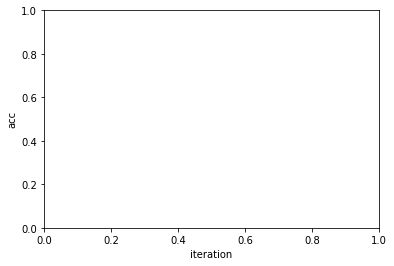

In [49]:
plt.xlabel("iteration")
plt.ylabel("acc")
epoch_list = []
acc_list = []
acc_list_test = []

In [50]:
for epoch in range(500):
    epoch_list.append(epoch)
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x.float())
    # Compute and print loss
    loss = criterion(y_pred, y)

    ct, ttl_ct = 0, 0

    y_pred_temp = y_pred.detach().numpy()
    y_temp = y.detach().numpy()
    for i in range(len(y_pred_temp)):
        ct += (np.argmax(y_pred_temp[i]) == np.argmax(y_temp[i]))
        ttl_ct += 1

    acc = ct / ttl_ct
    acc_list.append(acc)

    emos_pred = model(torch.tensor(test_tokens).float())
    emos_pred = emos_pred.detach().numpy()

    ct, ttl_ct = 0, 0

    for i in range(len(emos_pred)):
        ct += (np.argmax(emos_pred[i]) == np.argmax(test_emos[i]))
        ttl_ct += 1

    t_acc = ct / ttl_ct
    acc_list_test.append(t_acc)

    print('epoch: ', epoch, ' loss: ', loss.item(), ' accuracy: ', acc)
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    # perform a backward pass (backpropagation)
    loss.backward()
    # Update the parameters
    optimizer.step()

epoch:  0  loss:  0.25629091262817383  accuracy:  0.0336
epoch:  1  loss:  0.2561592757701874  accuracy:  0.033725
epoch:  2  loss:  0.2560276687145233  accuracy:  0.033925
epoch:  3  loss:  0.25589612126350403  accuracy:  0.03405
epoch:  4  loss:  0.2557646334171295  accuracy:  0.0339
epoch:  5  loss:  0.255633145570755  accuracy:  0.03395
epoch:  6  loss:  0.25550171732902527  accuracy:  0.033925
epoch:  7  loss:  0.2553703188896179  accuracy:  0.033775
epoch:  8  loss:  0.25523898005485535  accuracy:  0.0338
epoch:  9  loss:  0.25510767102241516  accuracy:  0.033875
epoch:  10  loss:  0.254976361989975  accuracy:  0.033925
epoch:  11  loss:  0.25484511256217957  accuracy:  0.033825
epoch:  12  loss:  0.25471386313438416  accuracy:  0.0339
epoch:  13  loss:  0.25458261370658875  accuracy:  0.033975
epoch:  14  loss:  0.2544513940811157  accuracy:  0.0341
epoch:  15  loss:  0.2543202042579651  accuracy:  0.0341
epoch:  16  loss:  0.25418901443481445  accuracy:  0.034175
epoch:  17  lo

In [51]:
emos_pred = model(torch.tensor(test_tokens).float())
emos_pred = emos_pred.detach().numpy()

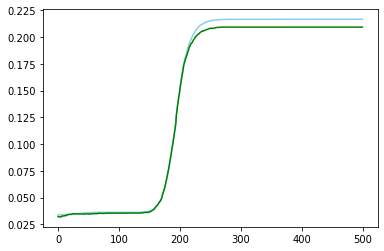

In [52]:
plt.plot(epoch_list, acc_list, color='skyblue', label='test')
plt.plot(epoch_list, acc_list_test, color='green', label='train')
plt.show()

In [53]:
ct, ttl_ct = 0, 0

for i in range(len(emos_pred)):
    ct += (np.argmax(emos_pred[i]) == np.argmax(test_emos[i]))
    ttl_ct += 1

ct / ttl_ct

0.20932093209320932

In [54]:
torch.save(model.state_dict(), 'nn_BoW.pt')